In [1]:
def updateData():
    import tweepy as tp
    import re
    import string
    import pandas as pd
    from datetime import datetime, timedelta
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    from sqlalchemy import create_engine
        
    consumer_key = 'D7Ch0N24KVqLpwk7jVgwbNHtT'
    consumer_secret = 'hrqTxd1tueHNuEmdwqNtXPyplHYpgYIOJRGw662NyIu6sYYsPD'
    access_token = '1288033810722852869-zJeJ6zkxdhFuHpgLRhTd5NhLcmygNh'
    access_token_secret = '6TNEDjmX4kTl0UFNFRpZoGb3p2D5TycvZ9d6hh9pK2Lia'
    
    auth = tp.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tp.API(auth)
        
    keyword = 'vaksin covid'
    newKeyword = keyword + " -filter:retweets"
    ndays=2
    dateRange = datetime.now() - timedelta(days=ndays)
    date_since = dateRange.strftime('%Y-%m-%d')
    date_now = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
        
    tweets = tp.Cursor(api.search, q=newKeyword, lang="id", since=date_since, until=date_now,tweet_mode="extended").items(1000)
#     tweets = api.search(q=newKeyword, lang='id', until=date_now, since=date_since, tweet_mode='extended')
    items = []
    
    for tweet in tweets:
        item = []
        sn = tweet.user.screen_name
        date = tweet.created_at
        text = tweet.full_text #get full text
        text = text.strip() #remove empty char
        text = text.lower() #to lowercase
        text = re.sub(r"\d+", "", text) #remove number
        text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation
        factory = StopWordRemoverFactory()
        stopword = factory.create_stop_word_remover()
        text = stopword.remove(text)
        item.append(sn)
        item.append(text)
        item.append(date.strftime('%Y-%m-%d'))
        item.append('-')
        items.append(item)
    
    pd.options.display.max_colwidth = 300
    df = pd.DataFrame(data=items, columns=['user', 'tweet', 'date', 'sentiment'])
    
    engine = create_engine('sqlite:///TugasAkhirDataScience.db', echo=True)
    sqlite_connection = engine.connect()
    
    sqlite_table = "tweet_data"
    df.to_sql(sqlite_table, sqlite_connection, if_exists='append', index=False)

In [2]:
updateData()

2020-08-13 17:33:23,085 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-08-13 17:33:23,091 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:33:23,093 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-08-13 17:33:23,095 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:33:23,103 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("tweet_data")
2020-08-13 17:33:23,105 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:33:23,111 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-08-13 17:33:23,133 INFO sqlalchemy.engine.base.Engine INSERT INTO tweet_data (user, tweet, date, sentiment) VALUES (?, ?, ?, ?)
2020-08-13 17:33:23,200 INFO sqlalchemy.engine.base.Engine (('AyraLubis', 'bangsa kaget bukan berhasil uji vaksin karena indonesia mau jadi kelinci percobaan gitu coyy😀😀\n\nerick thohir bangsabangsa kaget kita berhasil uji vaksin covid perdana\n\nhttpstcogerprxpj', '2020

In [6]:
def updateSentiment():
    import sqlalchemy as db
    import pandas as pd
    
    engine = db.create_engine('sqlite:///TugasAkhirDataScience.db', echo=True)
    sqlite_connection = engine.connect()
    metadata = db.MetaData()
    tweet_data = db.Table('tweet_data', metadata, autoload=True, autoload_with=engine)
    query = db.select([tweet_data])
    ResultProxy = sqlite_connection.execute(query)
    ResultSet = ResultProxy.fetchall()
    
    df = pd.DataFrame(ResultSet)
    df.columns = ResultSet[0].keys()
    df = df.drop_duplicates(subset='tweet', keep='first')
    
    pos_list= open("kata_positif.txt","r")
    pos_kata = pos_list.readlines()
    neg_list= open("kata_negatif.txt","r")
    neg_kata = neg_list.readlines()
    
    s = []
    for index, data in df.iterrows():
        count_p = 0
        count_n = 0
        for kata_pos in pos_kata:
            if kata_pos.strip() in data['tweet']:
                count_p +=1
        for kata_neg in neg_kata:
            if kata_neg.strip() in data['tweet']:
                count_n +=1
        sentiment = count_p - count_n
        s.append(sentiment)
        
    df['sentiment'] = s
    
    sqlite_table = "tweet_sentiment"
    df.to_sql(sqlite_table, sqlite_connection, if_exists='replace', index=False)

#     with engine.begin() as cn:
#         sql = """INSERT INTO tweet_sentiment (user, tweet, date, sentiment)
#             SELECT t.user, t.tweet, t.date, t.sentiment
#             FROM tweet_sentiment t
#             WHERE NOT EXISTS 
#                 (SELECT 1 FROM tweet_sentiment f
#                  WHERE t.user = f.user
#                  AND t.tweet = f.tweet)"""

#         cn.execute(sql)

In [7]:
updateSentiment()

2020-08-13 17:40:29,248 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-08-13 17:40:29,250 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:40:29,253 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-08-13 17:40:29,255 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:40:29,259 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("tweet_data")
2020-08-13 17:40:29,262 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:40:29,265 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'tweet_data' AND type = 'table'
2020-08-13 17:40:29,267 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:40:29,270 INFO sqlalchemy.engine.base.Engine PRAGMA main.foreign_key_list("tweet_data")
2020-08-13 17:40:29,272 INFO sqlalchemy.engine.base.Engine ()
2020-08-13 17:40:29,275 INFO sqlalchemy.engine.base.Engine

In [46]:
def lihatData(since, until):
    import sqlalchemy as db
    import pandas as pd
    
    engine = db.create_engine('sqlite:///TugasAkhirDataScience.db', echo=True)
    sqlite_connection = engine.connect()
    metadata = db.MetaData()
    tweet_sentiment = db.Table('tweet_sentiment', metadata, autoload=True, autoload_with=engine)

    ResultProxy = sqlite_connection.execute("SELECT * FROM tweet_sentiment WHERE date BETWEEN :since AND :until", {'since': since, 'until': until})
    ResultSet = ResultProxy.fetchall()
    
    df = pd.DataFrame(ResultSet)
    return df

In [48]:
da = lihatData('2020-08-12', '2020-08-12')
da

2020-08-12 22:32:26,854 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-08-12 22:32:26,856 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:32:26,859 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-08-12 22:32:26,860 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:32:26,864 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("tweet_sentiment")
2020-08-12 22:32:26,866 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:32:26,870 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'tweet_sentiment' AND type = 'table'
2020-08-12 22:32:26,872 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:32:26,876 INFO sqlalchemy.engine.base.Engine PRAGMA main.foreign_key_list("tweet_sentiment")
2020-08-12 22:32:26,878 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:32:26,880 INFO sqlalchemy.eng

,0,1,2,3
0,pakguruhonorer,rusia memproduksi vaksin buatannya bulan september nama sputnikv\nhttpstcownaoyt,2020-08-12,0
1,betinagarang,subtanyarl de besok aa kerumah mau ketemu papa terus lamar dede \nbreaking news covid hilang sudah vaksin nya\nini yg paling ditunggu🥰🥰,2020-08-12,-4
2,jurnascom,menkes murashko tepis keraguan kemampuan vaksin covid rusia httpstcoeghywhiiy httpstcodhhnbzani,2020-08-12,0
3,irmawindya,dheejhe mobil haluu nasib vaksin covid kuatir nya ga jauh dari,2020-08-12,0
4,SulSelSatu,bio farma suntikan dana rp t pengembangan vaksin covid httpstcobmwqdgwe httpstcocqamizzpjv,2020-08-12,1
...,...,...,...,...
625,uknee11,kunjungan presiden clin trial fase vaksin covid kemarin berpengaruh penelitian pengembangan vaksin dilakukan konsorsium nasionalhal penting yg diperhatikan\ndi indonesia sejak bbrp tahun lalu diprakarsai kemenristek konsorsium life science,2020-08-12,3
626,NurahmaTity,luar biasa ridwankamil mendaftar jadi relawan uji klinis vaksin covid\nberani digarda terdepan jabar juara\n\npplhiupdate jabarjuaralahirbatin rkjabarjuara jabarterbaiktanganicovid humasjabar \n\nridwankamil ramrammukhlis fhmymchtr httpstcokxnatmprh,2020-08-12,8
627,ElshintaDotcom,as teken kontrak pembelian vaksin covid moderna senilai rp triliun\nhttpstcorjcwqoezuh httpstcoeutwngwa,2020-08-12,-1
628,republikaonline,penasihat senior gedung mengatakan trump umumkan perkembangan vaksin httpstcojjpavtbtl,2020-08-12,0


In [61]:
def visualize(since, until):
    import sqlalchemy as db
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    engine = db.create_engine('sqlite:///TugasAkhirDataScience.db', echo=True)
    sqlite_connection = engine.connect()
    metadata = db.MetaData()
    tweet_sentiment = db.Table('tweet_sentiment', metadata, autoload=True, autoload_with=engine)

    ResultProxy = sqlite_connection.execute("SELECT * FROM tweet_sentiment WHERE date BETWEEN :since AND :until", {'since': since, 'until': until})
    ResultSet = ResultProxy.fetchall()
    
    df = pd.DataFrame(ResultSet)
    
    labels, counts = np.unique(df[3], return_counts=True)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.bar(labels, counts, align='center')
    ax.set_title('Sentiment terhadap topik tentang vaksin covid')
    plt.show()
    print('Nilai rata-rata: ', np.mean(df[3]))
    print('Nilai Median: ', np.median(df[3]))
    print('Standar deviasi: ', np.std(df[3]))

2020-08-12 22:52:20,026 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-08-12 22:52:20,028 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:52:20,030 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-08-12 22:52:20,032 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:52:20,036 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("tweet_sentiment")
2020-08-12 22:52:20,039 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:52:20,043 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'tweet_sentiment' AND type = 'table'
2020-08-12 22:52:20,046 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:52:20,049 INFO sqlalchemy.engine.base.Engine PRAGMA main.foreign_key_list("tweet_sentiment")
2020-08-12 22:52:20,052 INFO sqlalchemy.engine.base.Engine ()
2020-08-12 22:52:20,054 INFO sqlalchemy.eng

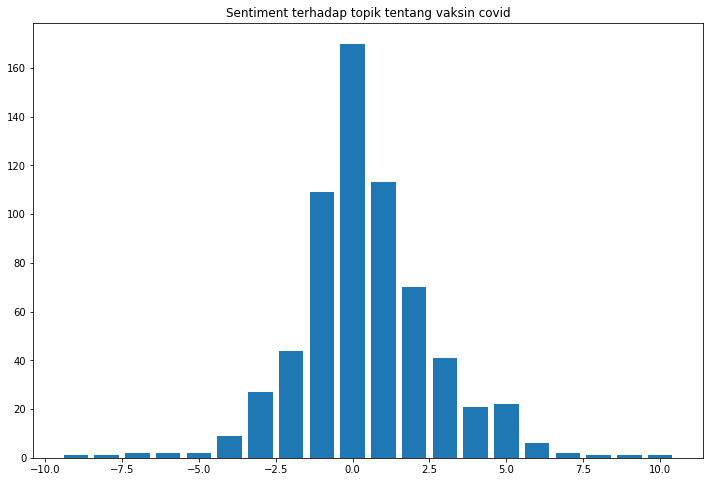

Nilai rata-rata:  0.43410852713178294
Nilai Median:  0.0
Standar deviasi:  2.200228886050846


In [62]:
visualize('2020-08-11', '2020-08-12')